Running Untargeted Patch Attack: 100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


Saved to AdversarialTestSets/adv_test_set3_untargeted.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].


Patch Top-1: 67.80%, Top-5: 90.80%
Mean L∞: 0.10000, Max L∞: 0.10000 (ε = 0.5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].


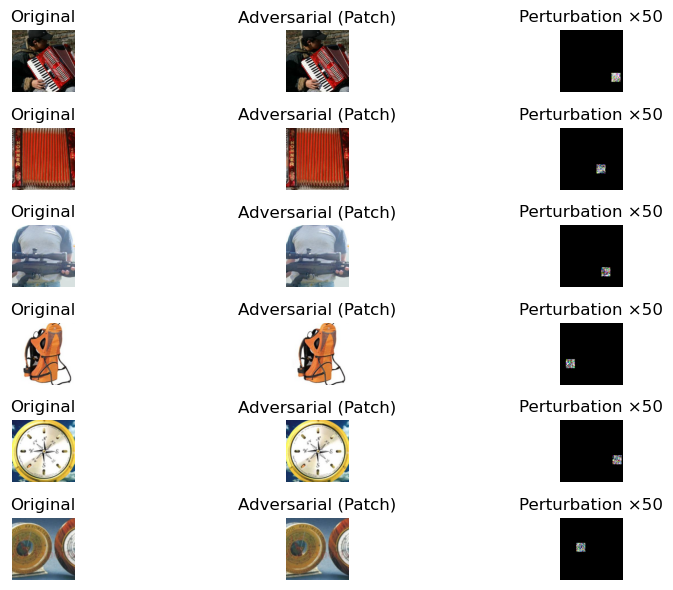

In [6]:
import os, json, ast, requests
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Config ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epsilon = 0.5
alpha = 0.05
steps = 2
patch_size = 32
BATCH_SIZE = 64

mean_vals = torch.tensor([0.485, 0.456, 0.406])[:, None, None].to(device)
std_vals  = torch.tensor([0.229, 0.224, 0.225])[:, None, None].to(device)

# --- Load ResNet-34 ---
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1).to(device).eval()

# --- Load clean dataset (used in Task 1) ---
DATASET_PATH = "./test_dataset"
LABELS_JSON = os.path.join(DATASET_PATH, "labels_list.json")

with open(LABELS_JSON, "r") as f:
    entries = json.load(f)
subset_indices = [int(e.split(":")[0]) for e in entries]

url = "https://gist.githubusercontent.com/fnielsen/4a5c94eaa6dcdf29b7a62d886f540372/raw/imagenet_label_to_wordnet_synset.txt"
synset_text = requests.get(url).text
synset_map = ast.literal_eval(synset_text)

idx_to_wnid = {}
for idx_str, info in synset_map.items():
    idx = int(idx_str)
    if idx in subset_indices:
        wnid = "n" + info["id"].split("-")[0]
        idx_to_wnid[idx] = wnid
wnid_to_global = {wnid: idx for idx, wnid in idx_to_wnid.items()}
valid_wnids = set(wnid_to_global.keys())

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_vals[:, 0, 0], std=std_vals[:, 0, 0])
])

class FilteredImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d)) and d in valid_wnids]
        if not dirs:
            raise ValueError("No matching WNID folders found.")
        dirs.sort()
        return dirs, {cls_name: i for i, cls_name in enumerate(dirs)}

base_ds = FilteredImageFolder(DATASET_PATH, transform=transform)
folder_to_global = {i: wnid_to_global[wnid] for i, wnid in enumerate(base_ds.classes)}

class SubsetDataset(Dataset):
    def __init__(self, base_ds, index_map):
        self.base = base_ds
        self.index_map = index_map
    def __len__(self): return len(self.base)
    def __getitem__(self, idx):
        img, folder_idx = self.base[idx]
        return img, self.index_map[folder_idx]

dataset = SubsetDataset(base_ds, folder_to_global)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- Patch Attack (PGD on 32x32) ---
def patch_pgd_attack(model, x, y, patch_size, eps, alpha, steps):
    B, C, H, W = x.size()
    x = x.clone().detach().to(device)
    y = y.to(device)
    x_orig = x.clone().detach()
    adv = x.clone().detach()

    top = torch.randint(0, H - patch_size, (B,))
    left = torch.randint(0, W - patch_size, (B,))

    for _ in range(steps):
        adv.requires_grad = True
        logits = model(adv)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        grad = adv.grad.detach()

        updated = []
        for i in range(B):
            t, l = top[i], left[i]
            adv_i = adv[i].clone()
            grad_i = grad[i]
            patch_grad = grad_i[:, t:t+patch_size, l:l+patch_size].sign()
            patch = adv_i[:, t:t+patch_size, l:l+patch_size] + alpha * patch_grad
            adv_i[:, t:t+patch_size, l:l+patch_size] = patch
            delta = adv_i - x_orig[i]
            delta = torch.clamp(delta, -eps, eps)
            adv_i = x_orig[i] + delta
            clip_min = (0.0 - mean_vals) / std_vals
            clip_max = (1.0 - mean_vals) / std_vals
            adv_i = torch.max(torch.min(adv_i, clip_max), clip_min)
            updated.append(adv_i)

        adv = torch.stack(updated).detach()

    return adv, top, left

# --- Run attack ---
adv_imgs, adv_lbls, orig_imgs, triplets = [], [], [], []

for x, y in tqdm(loader, desc="Running Untargeted Patch Attack"):
    orig_imgs.append(x.clone())
    x = x.to(device)
    adv, tops, lefts = patch_pgd_attack(model, x, y, patch_size, epsilon, alpha, steps)
    adv_imgs.append(adv.cpu())
    adv_lbls.append(y)

    if len(triplets) < 5:
        for i in range(min(2, x.size(0))):
            o, a = x[i].cpu(), adv[i].cpu()
            triplets.append((o, a, a - o))

adv_imgs_tensor = torch.cat(adv_imgs)
adv_lbls_tensor = torch.cat(adv_lbls)
orig_tensor = torch.cat(orig_imgs)

os.makedirs("AdversarialTestSets", exist_ok=True)
torch.save({"images": adv_imgs_tensor, "labels": adv_lbls_tensor}, "AdversarialTestSets/adv_test_set3_untargeted.pt")
print("Saved to AdversarialTestSets/adv_test_set3_untargeted.pt")

# --- Evaluate ---
@torch.no_grad()
def evaluate(model, loader, topk=(1, 5)):
    correct, total = {k: 0 for k in topk}, {k: 0 for k in topk}
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        _, preds = logits.topk(max(topk), dim=1)
        for k in topk:
            correct[k] += (preds[:, :k] == y.unsqueeze(1)).any(dim=1).sum().item()
            total[k] += y.size(0)
    return {k: correct[k] / total[k] for k in topk}

acc = evaluate(model, DataLoader(TensorDataset(adv_imgs_tensor, adv_lbls_tensor), batch_size=BATCH_SIZE))
print(f"Patch Top-1: {acc[1]*100:.2f}%, Top-5: {acc[5]*100:.2f}%")

# --- L∞ Distance ---
linf = (adv_imgs_tensor - orig_tensor).abs().view(len(orig_tensor), -1).max(dim=1)[0]
print(f"Mean L∞: {linf.mean():.5f}, Max L∞: {linf.max():.5f} (ε = {epsilon})")

# --- Visualize ---
def denorm(img): return (img * std_vals.cpu()) + mean_vals.cpu()
fig, axes = plt.subplots(len(triplets), 3, figsize=(10, 6))
for i, (o, a, d) in enumerate(triplets):
    axes[i][0].imshow(denorm(o).permute(1, 2, 0).clip(0, 1)); axes[i][0].set_title("Original")
    axes[i][1].imshow(denorm(a).permute(1, 2, 0).clip(0, 1)); axes[i][1].set_title("Adversarial (Patch)")
    axes[i][2].imshow((d).permute(1, 2, 0).abs().clip(0, 0.05) * 50); axes[i][2].set_title("Perturbation ×50")
    for ax in axes[i]: ax.axis('off')
plt.tight_layout()
os.makedirs("Patch_Visualizations", exist_ok=True)
plt.savefig("Patch_Visualizations/untargeted_patch_visualization_2.png")
plt.show()


Running Untargeted Patch Attack: 100%|██████████| 8/8 [00:05<00:00,  1.58it/s]


Saved to AdversarialTestSets/adv_test_set3_untargeted.pt
Patch Top-1: 56.20%, Top-5: 87.00%
Mean L∞: 0.25000, Max L∞: 0.25000 (ε = 0.5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].


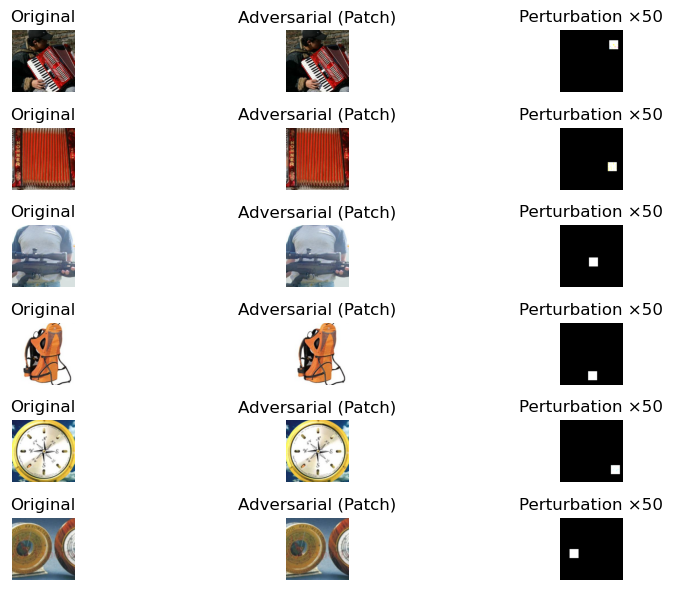

In [7]:
import os, json, ast, requests
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Config ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epsilon = 0.5
alpha = 0.05
steps = 5
patch_size = 32
BATCH_SIZE = 64

mean_vals = torch.tensor([0.485, 0.456, 0.406])[:, None, None].to(device)
std_vals  = torch.tensor([0.229, 0.224, 0.225])[:, None, None].to(device)

# --- Load ResNet-34 ---
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1).to(device).eval()

# --- Load clean dataset (used in Task 1) ---
DATASET_PATH = "./test_dataset"
LABELS_JSON = os.path.join(DATASET_PATH, "labels_list.json")

with open(LABELS_JSON, "r") as f:
    entries = json.load(f)
subset_indices = [int(e.split(":")[0]) for e in entries]

url = "https://gist.githubusercontent.com/fnielsen/4a5c94eaa6dcdf29b7a62d886f540372/raw/imagenet_label_to_wordnet_synset.txt"
synset_text = requests.get(url).text
synset_map = ast.literal_eval(synset_text)

idx_to_wnid = {}
for idx_str, info in synset_map.items():
    idx = int(idx_str)
    if idx in subset_indices:
        wnid = "n" + info["id"].split("-")[0]
        idx_to_wnid[idx] = wnid
wnid_to_global = {wnid: idx for idx, wnid in idx_to_wnid.items()}
valid_wnids = set(wnid_to_global.keys())

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_vals[:, 0, 0], std=std_vals[:, 0, 0])
])

class FilteredImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d)) and d in valid_wnids]
        if not dirs:
            raise ValueError("No matching WNID folders found.")
        dirs.sort()
        return dirs, {cls_name: i for i, cls_name in enumerate(dirs)}

base_ds = FilteredImageFolder(DATASET_PATH, transform=transform)
folder_to_global = {i: wnid_to_global[wnid] for i, wnid in enumerate(base_ds.classes)}

class SubsetDataset(Dataset):
    def __init__(self, base_ds, index_map):
        self.base = base_ds
        self.index_map = index_map
    def __len__(self): return len(self.base)
    def __getitem__(self, idx):
        img, folder_idx = self.base[idx]
        return img, self.index_map[folder_idx]

dataset = SubsetDataset(base_ds, folder_to_global)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- Patch Attack (PGD on 32x32) ---
def patch_pgd_attack(model, x, y, patch_size, eps, alpha, steps):
    B, C, H, W = x.size()
    x = x.clone().detach().to(device)
    y = y.to(device)
    x_orig = x.clone().detach()
    adv = x.clone().detach()

    top = torch.randint(0, H - patch_size, (B,))
    left = torch.randint(0, W - patch_size, (B,))

    for _ in range(steps):
        adv.requires_grad = True
        logits = model(adv)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        grad = adv.grad.detach()

        updated = []
        for i in range(B):
            t, l = top[i], left[i]
            adv_i = adv[i].clone()
            grad_i = grad[i]
            patch_grad = grad_i[:, t:t+patch_size, l:l+patch_size].sign()
            patch = adv_i[:, t:t+patch_size, l:l+patch_size] + alpha * patch_grad
            adv_i[:, t:t+patch_size, l:l+patch_size] = patch
            delta = adv_i - x_orig[i]
            delta = torch.clamp(delta, -eps, eps)
            adv_i = x_orig[i] + delta
            clip_min = (0.0 - mean_vals) / std_vals
            clip_max = (1.0 - mean_vals) / std_vals
            adv_i = torch.max(torch.min(adv_i, clip_max), clip_min)
            updated.append(adv_i)

        adv = torch.stack(updated).detach()

    return adv, top, left

# --- Run attack ---
adv_imgs, adv_lbls, orig_imgs, triplets = [], [], [], []

for x, y in tqdm(loader, desc="Running Untargeted Patch Attack"):
    orig_imgs.append(x.clone())
    x = x.to(device)
    adv, tops, lefts = patch_pgd_attack(model, x, y, patch_size, epsilon, alpha, steps)
    adv_imgs.append(adv.cpu())
    adv_lbls.append(y)

    if len(triplets) < 5:
        for i in range(min(2, x.size(0))):
            o, a = x[i].cpu(), adv[i].cpu()
            triplets.append((o, a, a - o))

adv_imgs_tensor = torch.cat(adv_imgs)
adv_lbls_tensor = torch.cat(adv_lbls)
orig_tensor = torch.cat(orig_imgs)

os.makedirs("AdversarialTestSets", exist_ok=True)
torch.save({"images": adv_imgs_tensor, "labels": adv_lbls_tensor}, "AdversarialTestSets/adv_test_set3_untargeted.pt")
print("Saved to AdversarialTestSets/adv_test_set3_untargeted.pt")

# --- Evaluate ---
@torch.no_grad()
def evaluate(model, loader, topk=(1, 5)):
    correct, total = {k: 0 for k in topk}, {k: 0 for k in topk}
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        _, preds = logits.topk(max(topk), dim=1)
        for k in topk:
            correct[k] += (preds[:, :k] == y.unsqueeze(1)).any(dim=1).sum().item()
            total[k] += y.size(0)
    return {k: correct[k] / total[k] for k in topk}

acc = evaluate(model, DataLoader(TensorDataset(adv_imgs_tensor, adv_lbls_tensor), batch_size=BATCH_SIZE))
print(f"Patch Top-1: {acc[1]*100:.2f}%, Top-5: {acc[5]*100:.2f}%")

# --- L∞ Distance ---
linf = (adv_imgs_tensor - orig_tensor).abs().view(len(orig_tensor), -1).max(dim=1)[0]
print(f"Mean L∞: {linf.mean():.5f}, Max L∞: {linf.max():.5f} (ε = {epsilon})")

# --- Visualize ---
def denorm(img): return (img * std_vals.cpu()) + mean_vals.cpu()
fig, axes = plt.subplots(len(triplets), 3, figsize=(10, 6))
for i, (o, a, d) in enumerate(triplets):
    axes[i][0].imshow(denorm(o).permute(1, 2, 0).clip(0, 1)); axes[i][0].set_title("Original")
    axes[i][1].imshow(denorm(a).permute(1, 2, 0).clip(0, 1)); axes[i][1].set_title("Adversarial (Patch)")
    axes[i][2].imshow((d).permute(1, 2, 0).abs().clip(0, 0.05) * 50); axes[i][2].set_title("Perturbation ×50")
    for ax in axes[i]: ax.axis('off')
plt.tight_layout()
os.makedirs("Patch_Visualizations", exist_ok=True)
plt.savefig("Patch_Visualizations/untargeted_patch_visualization_5.png")
plt.show()


Running Untargeted Patch Attack: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Saved to AdversarialTestSets/adv_test_set3_untargeted.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].


Patch Top-1: 49.80%, Top-5: 83.20%
Mean L∞: 0.40000, Max L∞: 0.40000 (ε = 0.5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].


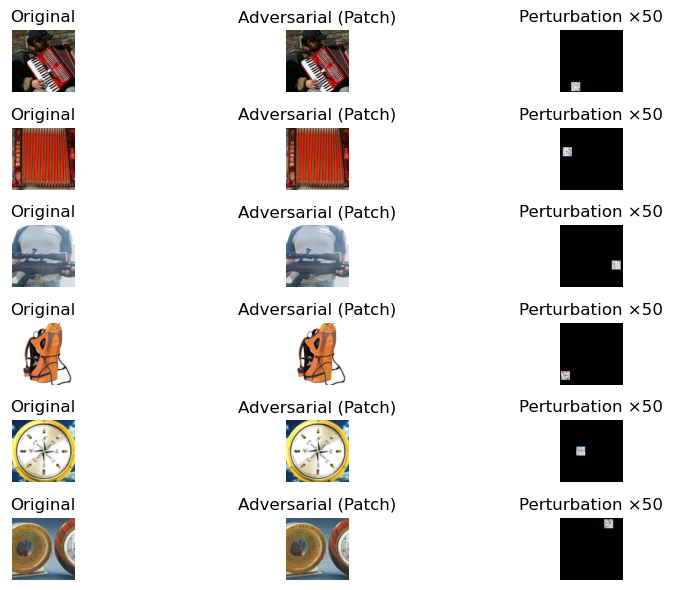

In [8]:
import os, json, ast, requests
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Config ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epsilon = 0.5
alpha = 0.05
steps = 8
patch_size = 32
BATCH_SIZE = 64

mean_vals = torch.tensor([0.485, 0.456, 0.406])[:, None, None].to(device)
std_vals  = torch.tensor([0.229, 0.224, 0.225])[:, None, None].to(device)

# --- Load ResNet-34 ---
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1).to(device).eval()

# --- Load clean dataset (used in Task 1) ---
DATASET_PATH = "./test_dataset"
LABELS_JSON = os.path.join(DATASET_PATH, "labels_list.json")

with open(LABELS_JSON, "r") as f:
    entries = json.load(f)
subset_indices = [int(e.split(":")[0]) for e in entries]

url = "https://gist.githubusercontent.com/fnielsen/4a5c94eaa6dcdf29b7a62d886f540372/raw/imagenet_label_to_wordnet_synset.txt"
synset_text = requests.get(url).text
synset_map = ast.literal_eval(synset_text)

idx_to_wnid = {}
for idx_str, info in synset_map.items():
    idx = int(idx_str)
    if idx in subset_indices:
        wnid = "n" + info["id"].split("-")[0]
        idx_to_wnid[idx] = wnid
wnid_to_global = {wnid: idx for idx, wnid in idx_to_wnid.items()}
valid_wnids = set(wnid_to_global.keys())

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_vals[:, 0, 0], std=std_vals[:, 0, 0])
])

class FilteredImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d)) and d in valid_wnids]
        if not dirs:
            raise ValueError("No matching WNID folders found.")
        dirs.sort()
        return dirs, {cls_name: i for i, cls_name in enumerate(dirs)}

base_ds = FilteredImageFolder(DATASET_PATH, transform=transform)
folder_to_global = {i: wnid_to_global[wnid] for i, wnid in enumerate(base_ds.classes)}

class SubsetDataset(Dataset):
    def __init__(self, base_ds, index_map):
        self.base = base_ds
        self.index_map = index_map
    def __len__(self): return len(self.base)
    def __getitem__(self, idx):
        img, folder_idx = self.base[idx]
        return img, self.index_map[folder_idx]

dataset = SubsetDataset(base_ds, folder_to_global)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- Patch Attack (PGD on 32x32) ---
def patch_pgd_attack(model, x, y, patch_size, eps, alpha, steps):
    B, C, H, W = x.size()
    x = x.clone().detach().to(device)
    y = y.to(device)
    x_orig = x.clone().detach()
    adv = x.clone().detach()

    top = torch.randint(0, H - patch_size, (B,))
    left = torch.randint(0, W - patch_size, (B,))

    for _ in range(steps):
        adv.requires_grad = True
        logits = model(adv)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        grad = adv.grad.detach()

        updated = []
        for i in range(B):
            t, l = top[i], left[i]
            adv_i = adv[i].clone()
            grad_i = grad[i]
            patch_grad = grad_i[:, t:t+patch_size, l:l+patch_size].sign()
            patch = adv_i[:, t:t+patch_size, l:l+patch_size] + alpha * patch_grad
            adv_i[:, t:t+patch_size, l:l+patch_size] = patch
            delta = adv_i - x_orig[i]
            delta = torch.clamp(delta, -eps, eps)
            adv_i = x_orig[i] + delta
            clip_min = (0.0 - mean_vals) / std_vals
            clip_max = (1.0 - mean_vals) / std_vals
            adv_i = torch.max(torch.min(adv_i, clip_max), clip_min)
            updated.append(adv_i)

        adv = torch.stack(updated).detach()

    return adv, top, left

# --- Run attack ---
adv_imgs, adv_lbls, orig_imgs, triplets = [], [], [], []

for x, y in tqdm(loader, desc="Running Untargeted Patch Attack"):
    orig_imgs.append(x.clone())
    x = x.to(device)
    adv, tops, lefts = patch_pgd_attack(model, x, y, patch_size, epsilon, alpha, steps)
    adv_imgs.append(adv.cpu())
    adv_lbls.append(y)

    if len(triplets) < 5:
        for i in range(min(2, x.size(0))):
            o, a = x[i].cpu(), adv[i].cpu()
            triplets.append((o, a, a - o))

adv_imgs_tensor = torch.cat(adv_imgs)
adv_lbls_tensor = torch.cat(adv_lbls)
orig_tensor = torch.cat(orig_imgs)

os.makedirs("AdversarialTestSets", exist_ok=True)
torch.save({"images": adv_imgs_tensor, "labels": adv_lbls_tensor}, "AdversarialTestSets/adv_test_set3_untargeted.pt")
print("Saved to AdversarialTestSets/adv_test_set3_untargeted.pt")

# --- Evaluate ---
@torch.no_grad()
def evaluate(model, loader, topk=(1, 5)):
    correct, total = {k: 0 for k in topk}, {k: 0 for k in topk}
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        _, preds = logits.topk(max(topk), dim=1)
        for k in topk:
            correct[k] += (preds[:, :k] == y.unsqueeze(1)).any(dim=1).sum().item()
            total[k] += y.size(0)
    return {k: correct[k] / total[k] for k in topk}

acc = evaluate(model, DataLoader(TensorDataset(adv_imgs_tensor, adv_lbls_tensor), batch_size=BATCH_SIZE))
print(f"Patch Top-1: {acc[1]*100:.2f}%, Top-5: {acc[5]*100:.2f}%")

# --- L∞ Distance ---
linf = (adv_imgs_tensor - orig_tensor).abs().view(len(orig_tensor), -1).max(dim=1)[0]
print(f"Mean L∞: {linf.mean():.5f}, Max L∞: {linf.max():.5f} (ε = {epsilon})")

# --- Visualize ---
def denorm(img): return (img * std_vals.cpu()) + mean_vals.cpu()
fig, axes = plt.subplots(len(triplets), 3, figsize=(10, 6))
for i, (o, a, d) in enumerate(triplets):
    axes[i][0].imshow(denorm(o).permute(1, 2, 0).clip(0, 1)); axes[i][0].set_title("Original")
    axes[i][1].imshow(denorm(a).permute(1, 2, 0).clip(0, 1)); axes[i][1].set_title("Adversarial (Patch)")
    axes[i][2].imshow((d).permute(1, 2, 0).abs().clip(0, 0.05) * 50); axes[i][2].set_title("Perturbation ×50")
    for ax in axes[i]: ax.axis('off')
plt.tight_layout()
os.makedirs("Patch_Visualizations", exist_ok=True)
plt.savefig("Patch_Visualizations/untargeted_patch_visualization_8.png")
plt.show()


Running Untargeted Patch Attack: 100%|██████████| 8/8 [00:09<00:00,  1.17s/it]


Saved to AdversarialTestSets/adv_test_set3_untargeted.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].


Patch Top-1: 45.20%, Top-5: 81.00%
Mean L∞: 0.49980, Max L∞: 0.50000 (ε = 0.5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].


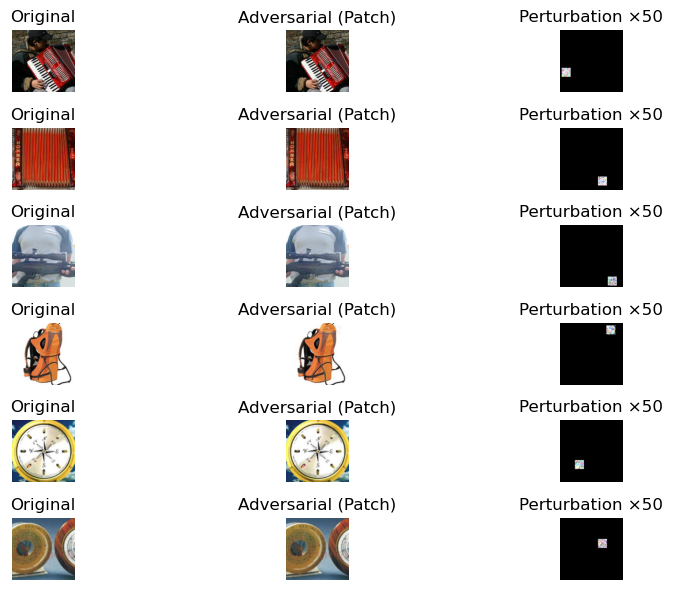

In [12]:
import os, json, ast, requests
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Config ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epsilon = 0.5
alpha = 0.05
steps = 10
patch_size = 32
BATCH_SIZE = 64

mean_vals = torch.tensor([0.485, 0.456, 0.406])[:, None, None].to(device)
std_vals  = torch.tensor([0.229, 0.224, 0.225])[:, None, None].to(device)

# --- Load ResNet-34 ---
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1).to(device).eval()

# --- Load clean dataset (used in Task 1) ---
DATASET_PATH = "./test_dataset"
LABELS_JSON = os.path.join(DATASET_PATH, "labels_list.json")

with open(LABELS_JSON, "r") as f:
    entries = json.load(f)
subset_indices = [int(e.split(":")[0]) for e in entries]

url = "https://gist.githubusercontent.com/fnielsen/4a5c94eaa6dcdf29b7a62d886f540372/raw/imagenet_label_to_wordnet_synset.txt"
synset_text = requests.get(url).text
synset_map = ast.literal_eval(synset_text)

idx_to_wnid = {}
for idx_str, info in synset_map.items():
    idx = int(idx_str)
    if idx in subset_indices:
        wnid = "n" + info["id"].split("-")[0]
        idx_to_wnid[idx] = wnid
wnid_to_global = {wnid: idx for idx, wnid in idx_to_wnid.items()}
valid_wnids = set(wnid_to_global.keys())

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_vals[:, 0, 0], std=std_vals[:, 0, 0])
])

class FilteredImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d)) and d in valid_wnids]
        if not dirs:
            raise ValueError("No matching WNID folders found.")
        dirs.sort()
        return dirs, {cls_name: i for i, cls_name in enumerate(dirs)}

base_ds = FilteredImageFolder(DATASET_PATH, transform=transform)
folder_to_global = {i: wnid_to_global[wnid] for i, wnid in enumerate(base_ds.classes)}

class SubsetDataset(Dataset):
    def __init__(self, base_ds, index_map):
        self.base = base_ds
        self.index_map = index_map
    def __len__(self): return len(self.base)
    def __getitem__(self, idx):
        img, folder_idx = self.base[idx]
        return img, self.index_map[folder_idx]

dataset = SubsetDataset(base_ds, folder_to_global)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- Patch Attack (PGD on 32x32) ---
def patch_pgd_attack(model, x, y, patch_size, eps, alpha, steps):
    B, C, H, W = x.size()
    x = x.clone().detach().to(device)
    y = y.to(device)
    x_orig = x.clone().detach()
    adv = x.clone().detach()

    top = torch.randint(0, H - patch_size, (B,))
    left = torch.randint(0, W - patch_size, (B,))

    for _ in range(steps):
        adv.requires_grad = True
        logits = model(adv)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        grad = adv.grad.detach()

        updated = []
        for i in range(B):
            t, l = top[i], left[i]
            adv_i = adv[i].clone()
            grad_i = grad[i]
            patch_grad = grad_i[:, t:t+patch_size, l:l+patch_size].sign()
            patch = adv_i[:, t:t+patch_size, l:l+patch_size] + alpha * patch_grad
            adv_i[:, t:t+patch_size, l:l+patch_size] = patch
            delta = adv_i - x_orig[i]
            delta = torch.clamp(delta, -eps, eps)
            adv_i = x_orig[i] + delta
            clip_min = (0.0 - mean_vals) / std_vals
            clip_max = (1.0 - mean_vals) / std_vals
            adv_i = torch.max(torch.min(adv_i, clip_max), clip_min)
            updated.append(adv_i)

        adv = torch.stack(updated).detach()

    return adv, top, left

# --- Run attack ---
adv_imgs, adv_lbls, orig_imgs, triplets = [], [], [], []

for x, y in tqdm(loader, desc="Running Untargeted Patch Attack"):
    orig_imgs.append(x.clone())
    x = x.to(device)
    adv, tops, lefts = patch_pgd_attack(model, x, y, patch_size, epsilon, alpha, steps)
    adv_imgs.append(adv.cpu())
    adv_lbls.append(y)

    if len(triplets) < 5:
        for i in range(min(2, x.size(0))):
            o, a = x[i].cpu(), adv[i].cpu()
            triplets.append((o, a, a - o))

adv_imgs_tensor = torch.cat(adv_imgs)
adv_lbls_tensor = torch.cat(adv_lbls)
orig_tensor = torch.cat(orig_imgs)

os.makedirs("AdversarialTestSets", exist_ok=True)
torch.save({"images": adv_imgs_tensor, "labels": adv_lbls_tensor}, "AdversarialTestSets/adv_test_set3_untargeted.pt")
print("Saved to AdversarialTestSets/adv_test_set3_untargeted.pt")

# --- Evaluate ---
@torch.no_grad()
def evaluate(model, loader, topk=(1, 5)):
    correct, total = {k: 0 for k in topk}, {k: 0 for k in topk}
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        _, preds = logits.topk(max(topk), dim=1)
        for k in topk:
            correct[k] += (preds[:, :k] == y.unsqueeze(1)).any(dim=1).sum().item()
            total[k] += y.size(0)
    return {k: correct[k] / total[k] for k in topk}

acc = evaluate(model, DataLoader(TensorDataset(adv_imgs_tensor, adv_lbls_tensor), batch_size=BATCH_SIZE))
print(f"Patch Top-1: {acc[1]*100:.2f}%, Top-5: {acc[5]*100:.2f}%")

# --- L∞ Distance ---
linf = (adv_imgs_tensor - orig_tensor).abs().view(len(orig_tensor), -1).max(dim=1)[0]
print(f"Mean L∞: {linf.mean():.5f}, Max L∞: {linf.max():.5f} (ε = {epsilon})")

# --- Visualize ---
def denorm(img): return (img * std_vals.cpu()) + mean_vals.cpu()
fig, axes = plt.subplots(len(triplets), 3, figsize=(10, 6))
for i, (o, a, d) in enumerate(triplets):
    axes[i][0].imshow(denorm(o).permute(1, 2, 0).clip(0, 1)); axes[i][0].set_title("Original")
    axes[i][1].imshow(denorm(a).permute(1, 2, 0).clip(0, 1)); axes[i][1].set_title("Adversarial (Patch)")
    axes[i][2].imshow((d).permute(1, 2, 0).abs().clip(0, 0.05) * 50); axes[i][2].set_title("Perturbation ×50")
    for ax in axes[i]: ax.axis('off')
plt.tight_layout()
os.makedirs("Patch_Visualizations", exist_ok=True)
plt.savefig("Patch_Visualizations/untargeted_patch_visualization_10.png")
plt.show()


Running Untargeted Patch Attack: 100%|██████████| 8/8 [00:13<00:00,  1.69s/it]


Saved to AdversarialTestSets/adv_test_set3_untargeted.pt
Patch Top-1: 40.20%, Top-5: 77.40%
Mean L∞: 0.50000, Max L∞: 0.50000 (ε = 0.5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].


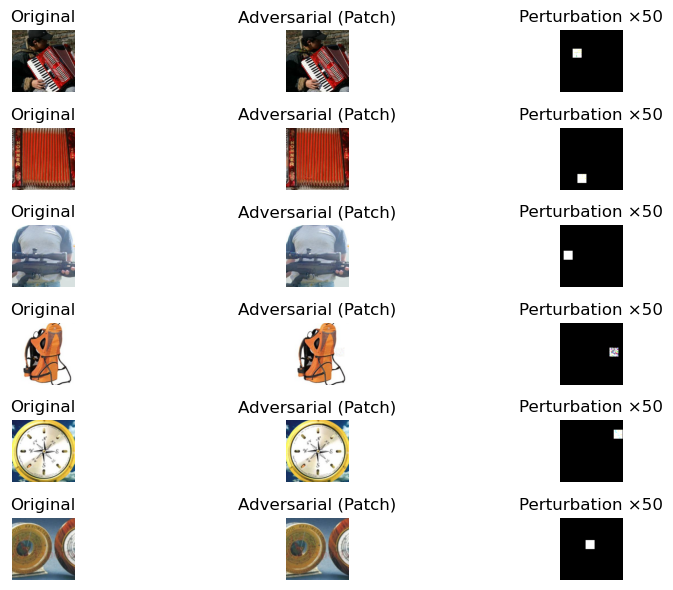

In [13]:
import os, json, ast, requests
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Config ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epsilon = 0.5
alpha = 0.05
steps = 15
patch_size = 32
BATCH_SIZE = 64

mean_vals = torch.tensor([0.485, 0.456, 0.406])[:, None, None].to(device)
std_vals  = torch.tensor([0.229, 0.224, 0.225])[:, None, None].to(device)

# --- Load ResNet-34 ---
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1).to(device).eval()

# --- Load clean dataset (used in Task 1) ---
DATASET_PATH = "./test_dataset"
LABELS_JSON = os.path.join(DATASET_PATH, "labels_list.json")

with open(LABELS_JSON, "r") as f:
    entries = json.load(f)
subset_indices = [int(e.split(":")[0]) for e in entries]

url = "https://gist.githubusercontent.com/fnielsen/4a5c94eaa6dcdf29b7a62d886f540372/raw/imagenet_label_to_wordnet_synset.txt"
synset_text = requests.get(url).text
synset_map = ast.literal_eval(synset_text)

idx_to_wnid = {}
for idx_str, info in synset_map.items():
    idx = int(idx_str)
    if idx in subset_indices:
        wnid = "n" + info["id"].split("-")[0]
        idx_to_wnid[idx] = wnid
wnid_to_global = {wnid: idx for idx, wnid in idx_to_wnid.items()}
valid_wnids = set(wnid_to_global.keys())

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_vals[:, 0, 0], std=std_vals[:, 0, 0])
])

class FilteredImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d)) and d in valid_wnids]
        if not dirs:
            raise ValueError("No matching WNID folders found.")
        dirs.sort()
        return dirs, {cls_name: i for i, cls_name in enumerate(dirs)}

base_ds = FilteredImageFolder(DATASET_PATH, transform=transform)
folder_to_global = {i: wnid_to_global[wnid] for i, wnid in enumerate(base_ds.classes)}

class SubsetDataset(Dataset):
    def __init__(self, base_ds, index_map):
        self.base = base_ds
        self.index_map = index_map
    def __len__(self): return len(self.base)
    def __getitem__(self, idx):
        img, folder_idx = self.base[idx]
        return img, self.index_map[folder_idx]

dataset = SubsetDataset(base_ds, folder_to_global)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- Patch Attack (PGD on 32x32) ---
def patch_pgd_attack(model, x, y, patch_size, eps, alpha, steps):
    B, C, H, W = x.size()
    x = x.clone().detach().to(device)
    y = y.to(device)
    x_orig = x.clone().detach()
    adv = x.clone().detach()

    top = torch.randint(0, H - patch_size, (B,))
    left = torch.randint(0, W - patch_size, (B,))

    for _ in range(steps):
        adv.requires_grad = True
        logits = model(adv)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        grad = adv.grad.detach()

        updated = []
        for i in range(B):
            t, l = top[i], left[i]
            adv_i = adv[i].clone()
            grad_i = grad[i]
            patch_grad = grad_i[:, t:t+patch_size, l:l+patch_size].sign()
            patch = adv_i[:, t:t+patch_size, l:l+patch_size] + alpha * patch_grad
            adv_i[:, t:t+patch_size, l:l+patch_size] = patch
            delta = adv_i - x_orig[i]
            delta = torch.clamp(delta, -eps, eps)
            adv_i = x_orig[i] + delta
            clip_min = (0.0 - mean_vals) / std_vals
            clip_max = (1.0 - mean_vals) / std_vals
            adv_i = torch.max(torch.min(adv_i, clip_max), clip_min)
            updated.append(adv_i)

        adv = torch.stack(updated).detach()

    return adv, top, left

# --- Run attack ---
adv_imgs, adv_lbls, orig_imgs, triplets = [], [], [], []

for x, y in tqdm(loader, desc="Running Untargeted Patch Attack"):
    orig_imgs.append(x.clone())
    x = x.to(device)
    adv, tops, lefts = patch_pgd_attack(model, x, y, patch_size, epsilon, alpha, steps)
    adv_imgs.append(adv.cpu())
    adv_lbls.append(y)

    if len(triplets) < 5:
        for i in range(min(2, x.size(0))):
            o, a = x[i].cpu(), adv[i].cpu()
            triplets.append((o, a, a - o))

adv_imgs_tensor = torch.cat(adv_imgs)
adv_lbls_tensor = torch.cat(adv_lbls)
orig_tensor = torch.cat(orig_imgs)

os.makedirs("AdversarialTestSets", exist_ok=True)
torch.save({"images": adv_imgs_tensor, "labels": adv_lbls_tensor}, "AdversarialTestSets/adv_test_set3_untargeted.pt")
print("Saved to AdversarialTestSets/adv_test_set3_untargeted.pt")

# --- Evaluate ---
@torch.no_grad()
def evaluate(model, loader, topk=(1, 5)):
    correct, total = {k: 0 for k in topk}, {k: 0 for k in topk}
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        _, preds = logits.topk(max(topk), dim=1)
        for k in topk:
            correct[k] += (preds[:, :k] == y.unsqueeze(1)).any(dim=1).sum().item()
            total[k] += y.size(0)
    return {k: correct[k] / total[k] for k in topk}

acc = evaluate(model, DataLoader(TensorDataset(adv_imgs_tensor, adv_lbls_tensor), batch_size=BATCH_SIZE))
print(f"Patch Top-1: {acc[1]*100:.2f}%, Top-5: {acc[5]*100:.2f}%")

# --- L∞ Distance ---
linf = (adv_imgs_tensor - orig_tensor).abs().view(len(orig_tensor), -1).max(dim=1)[0]
print(f"Mean L∞: {linf.mean():.5f}, Max L∞: {linf.max():.5f} (ε = {epsilon})")

# --- Visualize ---
def denorm(img): return (img * std_vals.cpu()) + mean_vals.cpu()
fig, axes = plt.subplots(len(triplets), 3, figsize=(10, 6))
for i, (o, a, d) in enumerate(triplets):
    axes[i][0].imshow(denorm(o).permute(1, 2, 0).clip(0, 1)); axes[i][0].set_title("Original")
    axes[i][1].imshow(denorm(a).permute(1, 2, 0).clip(0, 1)); axes[i][1].set_title("Adversarial (Patch)")
    axes[i][2].imshow((d).permute(1, 2, 0).abs().clip(0, 0.05) * 50); axes[i][2].set_title("Perturbation ×50")
    for ax in axes[i]: ax.axis('off')
plt.tight_layout()
os.makedirs("Patch_Visualizations", exist_ok=True)
plt.savefig("Patch_Visualizations/untargeted_patch_visualization_15.png")
plt.show()


Running Untargeted Patch Attack: 100%|██████████| 8/8 [00:17<00:00,  2.20s/it]


Saved to AdversarialTestSets/adv_test_set3_untargeted.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].


Patch Top-1: 33.80%, Top-5: 73.20%
Mean L∞: 0.50000, Max L∞: 0.50000 (ε = 0.5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].


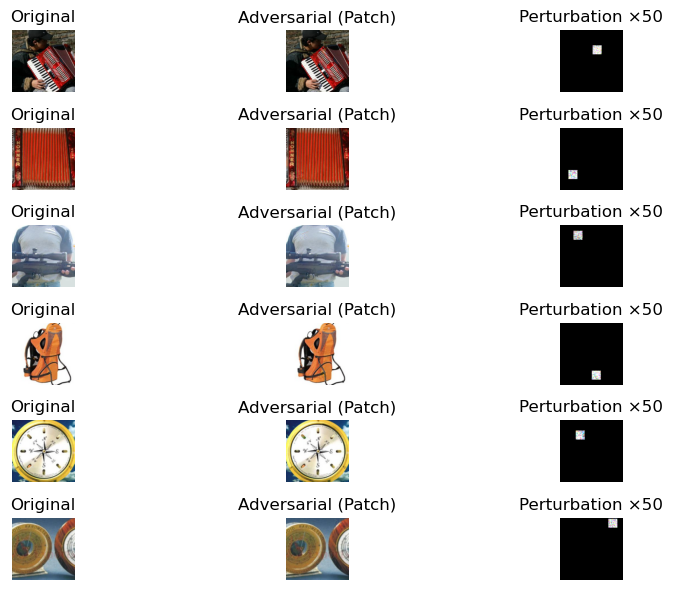

In [14]:
import os, json, ast, requests
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Config ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epsilon = 0.5
alpha = 0.05
steps = 20
patch_size = 32
BATCH_SIZE = 64

mean_vals = torch.tensor([0.485, 0.456, 0.406])[:, None, None].to(device)
std_vals  = torch.tensor([0.229, 0.224, 0.225])[:, None, None].to(device)

# --- Load ResNet-34 ---
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1).to(device).eval()

# --- Load clean dataset (used in Task 1) ---
DATASET_PATH = "./test_dataset"
LABELS_JSON = os.path.join(DATASET_PATH, "labels_list.json")

with open(LABELS_JSON, "r") as f:
    entries = json.load(f)
subset_indices = [int(e.split(":")[0]) for e in entries]

url = "https://gist.githubusercontent.com/fnielsen/4a5c94eaa6dcdf29b7a62d886f540372/raw/imagenet_label_to_wordnet_synset.txt"
synset_text = requests.get(url).text
synset_map = ast.literal_eval(synset_text)

idx_to_wnid = {}
for idx_str, info in synset_map.items():
    idx = int(idx_str)
    if idx in subset_indices:
        wnid = "n" + info["id"].split("-")[0]
        idx_to_wnid[idx] = wnid
wnid_to_global = {wnid: idx for idx, wnid in idx_to_wnid.items()}
valid_wnids = set(wnid_to_global.keys())

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_vals[:, 0, 0], std=std_vals[:, 0, 0])
])

class FilteredImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d)) and d in valid_wnids]
        if not dirs:
            raise ValueError("No matching WNID folders found.")
        dirs.sort()
        return dirs, {cls_name: i for i, cls_name in enumerate(dirs)}

base_ds = FilteredImageFolder(DATASET_PATH, transform=transform)
folder_to_global = {i: wnid_to_global[wnid] for i, wnid in enumerate(base_ds.classes)}

class SubsetDataset(Dataset):
    def __init__(self, base_ds, index_map):
        self.base = base_ds
        self.index_map = index_map
    def __len__(self): return len(self.base)
    def __getitem__(self, idx):
        img, folder_idx = self.base[idx]
        return img, self.index_map[folder_idx]

dataset = SubsetDataset(base_ds, folder_to_global)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- Patch Attack (PGD on 32x32) ---
def patch_pgd_attack(model, x, y, patch_size, eps, alpha, steps):
    B, C, H, W = x.size()
    x = x.clone().detach().to(device)
    y = y.to(device)
    x_orig = x.clone().detach()
    adv = x.clone().detach()

    top = torch.randint(0, H - patch_size, (B,))
    left = torch.randint(0, W - patch_size, (B,))

    for _ in range(steps):
        adv.requires_grad = True
        logits = model(adv)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        grad = adv.grad.detach()

        updated = []
        for i in range(B):
            t, l = top[i], left[i]
            adv_i = adv[i].clone()
            grad_i = grad[i]
            patch_grad = grad_i[:, t:t+patch_size, l:l+patch_size].sign()
            patch = adv_i[:, t:t+patch_size, l:l+patch_size] + alpha * patch_grad
            adv_i[:, t:t+patch_size, l:l+patch_size] = patch
            delta = adv_i - x_orig[i]
            delta = torch.clamp(delta, -eps, eps)
            adv_i = x_orig[i] + delta
            clip_min = (0.0 - mean_vals) / std_vals
            clip_max = (1.0 - mean_vals) / std_vals
            adv_i = torch.max(torch.min(adv_i, clip_max), clip_min)
            updated.append(adv_i)

        adv = torch.stack(updated).detach()

    return adv, top, left

# --- Run attack ---
adv_imgs, adv_lbls, orig_imgs, triplets = [], [], [], []

for x, y in tqdm(loader, desc="Running Untargeted Patch Attack"):
    orig_imgs.append(x.clone())
    x = x.to(device)
    adv, tops, lefts = patch_pgd_attack(model, x, y, patch_size, epsilon, alpha, steps)
    adv_imgs.append(adv.cpu())
    adv_lbls.append(y)

    if len(triplets) < 5:
        for i in range(min(2, x.size(0))):
            o, a = x[i].cpu(), adv[i].cpu()
            triplets.append((o, a, a - o))

adv_imgs_tensor = torch.cat(adv_imgs)
adv_lbls_tensor = torch.cat(adv_lbls)
orig_tensor = torch.cat(orig_imgs)

os.makedirs("AdversarialTestSets", exist_ok=True)
torch.save({"images": adv_imgs_tensor, "labels": adv_lbls_tensor}, "AdversarialTestSets/adv_test_set3_untargeted.pt")
print("Saved to AdversarialTestSets/adv_test_set3_untargeted.pt")

# --- Evaluate ---
@torch.no_grad()
def evaluate(model, loader, topk=(1, 5)):
    correct, total = {k: 0 for k in topk}, {k: 0 for k in topk}
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        _, preds = logits.topk(max(topk), dim=1)
        for k in topk:
            correct[k] += (preds[:, :k] == y.unsqueeze(1)).any(dim=1).sum().item()
            total[k] += y.size(0)
    return {k: correct[k] / total[k] for k in topk}

acc = evaluate(model, DataLoader(TensorDataset(adv_imgs_tensor, adv_lbls_tensor), batch_size=BATCH_SIZE))
print(f"Patch Top-1: {acc[1]*100:.2f}%, Top-5: {acc[5]*100:.2f}%")

# --- L∞ Distance ---
linf = (adv_imgs_tensor - orig_tensor).abs().view(len(orig_tensor), -1).max(dim=1)[0]
print(f"Mean L∞: {linf.mean():.5f}, Max L∞: {linf.max():.5f} (ε = {epsilon})")

# --- Visualize ---
def denorm(img): return (img * std_vals.cpu()) + mean_vals.cpu()
fig, axes = plt.subplots(len(triplets), 3, figsize=(10, 6))
for i, (o, a, d) in enumerate(triplets):
    axes[i][0].imshow(denorm(o).permute(1, 2, 0).clip(0, 1)); axes[i][0].set_title("Original")
    axes[i][1].imshow(denorm(a).permute(1, 2, 0).clip(0, 1)); axes[i][1].set_title("Adversarial (Patch)")
    axes[i][2].imshow((d).permute(1, 2, 0).abs().clip(0, 0.05) * 50); axes[i][2].set_title("Perturbation ×50")
    for ax in axes[i]: ax.axis('off')
plt.tight_layout()
os.makedirs("Patch_Visualizations", exist_ok=True)
plt.savefig("Patch_Visualizations/untargeted_patch_visualization_20.png")
plt.show()


Running Untargeted Patch Attack: 100%|██████████| 8/8 [00:34<00:00,  4.32s/it]


Saved to AdversarialTestSets/adv_test_set3_untargeted.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].


Patch Top-1: 23.80%, Top-5: 65.60%
Mean L∞: 0.50000, Max L∞: 0.50000 (ε = 0.5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].


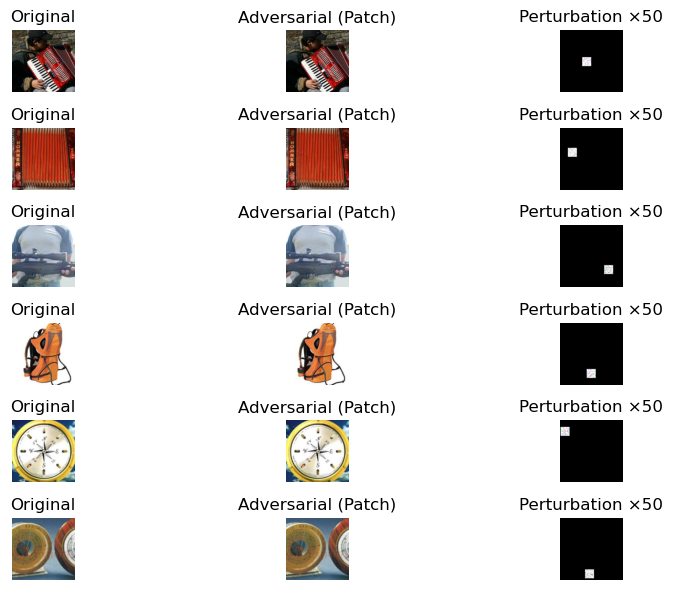

In [16]:
import os, json, ast, requests
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Config ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epsilon = 0.5
alpha = 0.05
steps = 40
patch_size = 32
BATCH_SIZE = 64

mean_vals = torch.tensor([0.485, 0.456, 0.406])[:, None, None].to(device)
std_vals  = torch.tensor([0.229, 0.224, 0.225])[:, None, None].to(device)

# --- Load ResNet-34 ---
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1).to(device).eval()

# --- Load clean dataset (used in Task 1) ---
DATASET_PATH = "./test_dataset"
LABELS_JSON = os.path.join(DATASET_PATH, "labels_list.json")

with open(LABELS_JSON, "r") as f:
    entries = json.load(f)
subset_indices = [int(e.split(":")[0]) for e in entries]

url = "https://gist.githubusercontent.com/fnielsen/4a5c94eaa6dcdf29b7a62d886f540372/raw/imagenet_label_to_wordnet_synset.txt"
synset_text = requests.get(url).text
synset_map = ast.literal_eval(synset_text)

idx_to_wnid = {}
for idx_str, info in synset_map.items():
    idx = int(idx_str)
    if idx in subset_indices:
        wnid = "n" + info["id"].split("-")[0]
        idx_to_wnid[idx] = wnid
wnid_to_global = {wnid: idx for idx, wnid in idx_to_wnid.items()}
valid_wnids = set(wnid_to_global.keys())

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_vals[:, 0, 0], std=std_vals[:, 0, 0])
])

class FilteredImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d)) and d in valid_wnids]
        if not dirs:
            raise ValueError("No matching WNID folders found.")
        dirs.sort()
        return dirs, {cls_name: i for i, cls_name in enumerate(dirs)}

base_ds = FilteredImageFolder(DATASET_PATH, transform=transform)
folder_to_global = {i: wnid_to_global[wnid] for i, wnid in enumerate(base_ds.classes)}

class SubsetDataset(Dataset):
    def __init__(self, base_ds, index_map):
        self.base = base_ds
        self.index_map = index_map
    def __len__(self): return len(self.base)
    def __getitem__(self, idx):
        img, folder_idx = self.base[idx]
        return img, self.index_map[folder_idx]

dataset = SubsetDataset(base_ds, folder_to_global)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- Patch Attack (PGD on 32x32) ---
def patch_pgd_attack(model, x, y, patch_size, eps, alpha, steps):
    B, C, H, W = x.size()
    x = x.clone().detach().to(device)
    y = y.to(device)
    x_orig = x.clone().detach()
    adv = x.clone().detach()

    top = torch.randint(0, H - patch_size, (B,))
    left = torch.randint(0, W - patch_size, (B,))

    for _ in range(steps):
        adv.requires_grad = True
        logits = model(adv)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        grad = adv.grad.detach()

        updated = []
        for i in range(B):
            t, l = top[i], left[i]
            adv_i = adv[i].clone()
            grad_i = grad[i]
            patch_grad = grad_i[:, t:t+patch_size, l:l+patch_size].sign()
            patch = adv_i[:, t:t+patch_size, l:l+patch_size] + alpha * patch_grad
            adv_i[:, t:t+patch_size, l:l+patch_size] = patch
            delta = adv_i - x_orig[i]
            delta = torch.clamp(delta, -eps, eps)
            adv_i = x_orig[i] + delta
            clip_min = (0.0 - mean_vals) / std_vals
            clip_max = (1.0 - mean_vals) / std_vals
            adv_i = torch.max(torch.min(adv_i, clip_max), clip_min)
            updated.append(adv_i)

        adv = torch.stack(updated).detach()

    return adv, top, left

# --- Run attack ---
adv_imgs, adv_lbls, orig_imgs, triplets = [], [], [], []

for x, y in tqdm(loader, desc="Running Untargeted Patch Attack"):
    orig_imgs.append(x.clone())
    x = x.to(device)
    adv, tops, lefts = patch_pgd_attack(model, x, y, patch_size, epsilon, alpha, steps)
    adv_imgs.append(adv.cpu())
    adv_lbls.append(y)

    if len(triplets) < 5:
        for i in range(min(2, x.size(0))):
            o, a = x[i].cpu(), adv[i].cpu()
            triplets.append((o, a, a - o))

adv_imgs_tensor = torch.cat(adv_imgs)
adv_lbls_tensor = torch.cat(adv_lbls)
orig_tensor = torch.cat(orig_imgs)

os.makedirs("AdversarialTestSets", exist_ok=True)
torch.save({"images": adv_imgs_tensor, "labels": adv_lbls_tensor}, "AdversarialTestSets/adv_test_set3_untargeted.pt")
print("Saved to AdversarialTestSets/adv_test_set3_untargeted.pt")

# --- Evaluate ---
@torch.no_grad()
def evaluate(model, loader, topk=(1, 5)):
    correct, total = {k: 0 for k in topk}, {k: 0 for k in topk}
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        _, preds = logits.topk(max(topk), dim=1)
        for k in topk:
            correct[k] += (preds[:, :k] == y.unsqueeze(1)).any(dim=1).sum().item()
            total[k] += y.size(0)
    return {k: correct[k] / total[k] for k in topk}

acc = evaluate(model, DataLoader(TensorDataset(adv_imgs_tensor, adv_lbls_tensor), batch_size=BATCH_SIZE))
print(f"Patch Top-1: {acc[1]*100:.2f}%, Top-5: {acc[5]*100:.2f}%")

# --- L∞ Distance ---
linf = (adv_imgs_tensor - orig_tensor).abs().view(len(orig_tensor), -1).max(dim=1)[0]
print(f"Mean L∞: {linf.mean():.5f}, Max L∞: {linf.max():.5f} (ε = {epsilon})")

# --- Visualize ---
def denorm(img): return (img * std_vals.cpu()) + mean_vals.cpu()
fig, axes = plt.subplots(len(triplets), 3, figsize=(10, 6))
for i, (o, a, d) in enumerate(triplets):
    axes[i][0].imshow(denorm(o).permute(1, 2, 0).clip(0, 1)); axes[i][0].set_title("Original")
    axes[i][1].imshow(denorm(a).permute(1, 2, 0).clip(0, 1)); axes[i][1].set_title("Adversarial (Patch)")
    axes[i][2].imshow((d).permute(1, 2, 0).abs().clip(0, 0.05) * 50); axes[i][2].set_title("Perturbation ×50")
    for ax in axes[i]: ax.axis('off')
plt.tight_layout()
os.makedirs("Patch_Visualizations", exist_ok=True)
plt.savefig("Patch_Visualizations/untargeted_patch_visualization_40.png")
plt.show()


Running Untargeted Patch Attack: 100%|██████████| 8/8 [01:08<00:00,  8.59s/it]


Saved to AdversarialTestSets/adv_test_set3_untargeted.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].


Patch Top-1: 20.40%, Top-5: 62.80%
Mean L∞: 0.50000, Max L∞: 0.50000 (ε = 0.5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].


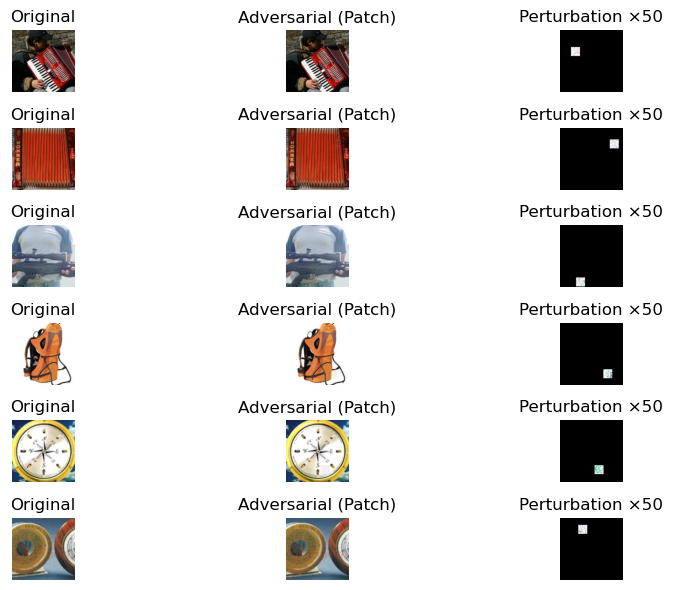

In [17]:
import os, json, ast, requests
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Config ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epsilon = 0.5
alpha = 0.05
steps = 80
patch_size = 32
BATCH_SIZE = 64

mean_vals = torch.tensor([0.485, 0.456, 0.406])[:, None, None].to(device)
std_vals  = torch.tensor([0.229, 0.224, 0.225])[:, None, None].to(device)

# --- Load ResNet-34 ---
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1).to(device).eval()

# --- Load clean dataset (used in Task 1) ---
DATASET_PATH = "./test_dataset"
LABELS_JSON = os.path.join(DATASET_PATH, "labels_list.json")

with open(LABELS_JSON, "r") as f:
    entries = json.load(f)
subset_indices = [int(e.split(":")[0]) for e in entries]

url = "https://gist.githubusercontent.com/fnielsen/4a5c94eaa6dcdf29b7a62d886f540372/raw/imagenet_label_to_wordnet_synset.txt"
synset_text = requests.get(url).text
synset_map = ast.literal_eval(synset_text)

idx_to_wnid = {}
for idx_str, info in synset_map.items():
    idx = int(idx_str)
    if idx in subset_indices:
        wnid = "n" + info["id"].split("-")[0]
        idx_to_wnid[idx] = wnid
wnid_to_global = {wnid: idx for idx, wnid in idx_to_wnid.items()}
valid_wnids = set(wnid_to_global.keys())

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_vals[:, 0, 0], std=std_vals[:, 0, 0])
])

class FilteredImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d)) and d in valid_wnids]
        if not dirs:
            raise ValueError("No matching WNID folders found.")
        dirs.sort()
        return dirs, {cls_name: i for i, cls_name in enumerate(dirs)}

base_ds = FilteredImageFolder(DATASET_PATH, transform=transform)
folder_to_global = {i: wnid_to_global[wnid] for i, wnid in enumerate(base_ds.classes)}

class SubsetDataset(Dataset):
    def __init__(self, base_ds, index_map):
        self.base = base_ds
        self.index_map = index_map
    def __len__(self): return len(self.base)
    def __getitem__(self, idx):
        img, folder_idx = self.base[idx]
        return img, self.index_map[folder_idx]

dataset = SubsetDataset(base_ds, folder_to_global)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- Patch Attack (PGD on 32x32) ---
def patch_pgd_attack(model, x, y, patch_size, eps, alpha, steps):
    B, C, H, W = x.size()
    x = x.clone().detach().to(device)
    y = y.to(device)
    x_orig = x.clone().detach()
    adv = x.clone().detach()

    top = torch.randint(0, H - patch_size, (B,))
    left = torch.randint(0, W - patch_size, (B,))

    for _ in range(steps):
        adv.requires_grad = True
        logits = model(adv)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        grad = adv.grad.detach()

        updated = []
        for i in range(B):
            t, l = top[i], left[i]
            adv_i = adv[i].clone()
            grad_i = grad[i]
            patch_grad = grad_i[:, t:t+patch_size, l:l+patch_size].sign()
            patch = adv_i[:, t:t+patch_size, l:l+patch_size] + alpha * patch_grad
            adv_i[:, t:t+patch_size, l:l+patch_size] = patch
            delta = adv_i - x_orig[i]
            delta = torch.clamp(delta, -eps, eps)
            adv_i = x_orig[i] + delta
            clip_min = (0.0 - mean_vals) / std_vals
            clip_max = (1.0 - mean_vals) / std_vals
            adv_i = torch.max(torch.min(adv_i, clip_max), clip_min)
            updated.append(adv_i)

        adv = torch.stack(updated).detach()

    return adv, top, left

# --- Run attack ---
adv_imgs, adv_lbls, orig_imgs, triplets = [], [], [], []

for x, y in tqdm(loader, desc="Running Untargeted Patch Attack"):
    orig_imgs.append(x.clone())
    x = x.to(device)
    adv, tops, lefts = patch_pgd_attack(model, x, y, patch_size, epsilon, alpha, steps)
    adv_imgs.append(adv.cpu())
    adv_lbls.append(y)

    if len(triplets) < 5:
        for i in range(min(2, x.size(0))):
            o, a = x[i].cpu(), adv[i].cpu()
            triplets.append((o, a, a - o))

adv_imgs_tensor = torch.cat(adv_imgs)
adv_lbls_tensor = torch.cat(adv_lbls)
orig_tensor = torch.cat(orig_imgs)

os.makedirs("AdversarialTestSets", exist_ok=True)
torch.save({"images": adv_imgs_tensor, "labels": adv_lbls_tensor}, "AdversarialTestSets/adv_test_set3_untargeted.pt")
print("Saved to AdversarialTestSets/adv_test_set3_untargeted.pt")

# --- Evaluate ---
@torch.no_grad()
def evaluate(model, loader, topk=(1, 5)):
    correct, total = {k: 0 for k in topk}, {k: 0 for k in topk}
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        _, preds = logits.topk(max(topk), dim=1)
        for k in topk:
            correct[k] += (preds[:, :k] == y.unsqueeze(1)).any(dim=1).sum().item()
            total[k] += y.size(0)
    return {k: correct[k] / total[k] for k in topk}

acc = evaluate(model, DataLoader(TensorDataset(adv_imgs_tensor, adv_lbls_tensor), batch_size=BATCH_SIZE))
print(f"Patch Top-1: {acc[1]*100:.2f}%, Top-5: {acc[5]*100:.2f}%")

# --- L∞ Distance ---
linf = (adv_imgs_tensor - orig_tensor).abs().view(len(orig_tensor), -1).max(dim=1)[0]
print(f"Mean L∞: {linf.mean():.5f}, Max L∞: {linf.max():.5f} (ε = {epsilon})")

# --- Visualize ---
def denorm(img): return (img * std_vals.cpu()) + mean_vals.cpu()
fig, axes = plt.subplots(len(triplets), 3, figsize=(10, 6))
for i, (o, a, d) in enumerate(triplets):
    axes[i][0].imshow(denorm(o).permute(1, 2, 0).clip(0, 1)); axes[i][0].set_title("Original")
    axes[i][1].imshow(denorm(a).permute(1, 2, 0).clip(0, 1)); axes[i][1].set_title("Adversarial (Patch)")
    axes[i][2].imshow((d).permute(1, 2, 0).abs().clip(0, 0.05) * 50); axes[i][2].set_title("Perturbation ×50")
    for ax in axes[i]: ax.axis('off')
plt.tight_layout()
os.makedirs("Patch_Visualizations", exist_ok=True)
plt.savefig("Patch_Visualizations/untargeted_patch_visualization_80.png")
plt.show()


Running Untargeted Patch Attack: 100%|██████████| 8/8 [02:08<00:00, 16.04s/it]


Saved to AdversarialTestSets/adv_test_set3_untargeted.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].


Patch Top-1: 15.00%, Top-5: 58.20%
Mean L∞: 0.50000, Max L∞: 0.50000 (ε = 0.5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].


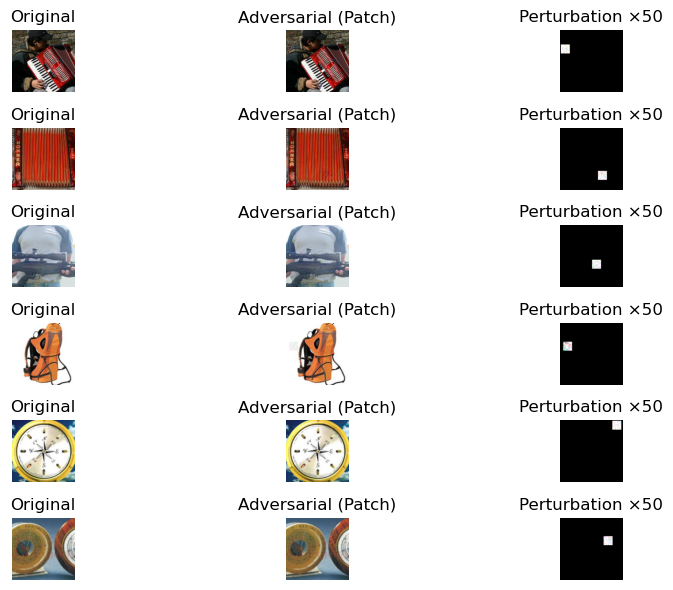

In [18]:
import os, json, ast, requests
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Config ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epsilon = 0.5
alpha = 0.05
steps = 150
patch_size = 32
BATCH_SIZE = 64

mean_vals = torch.tensor([0.485, 0.456, 0.406])[:, None, None].to(device)
std_vals  = torch.tensor([0.229, 0.224, 0.225])[:, None, None].to(device)

# --- Load ResNet-34 ---
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1).to(device).eval()

# --- Load clean dataset (used in Task 1) ---
DATASET_PATH = "./test_dataset"
LABELS_JSON = os.path.join(DATASET_PATH, "labels_list.json")

with open(LABELS_JSON, "r") as f:
    entries = json.load(f)
subset_indices = [int(e.split(":")[0]) for e in entries]

url = "https://gist.githubusercontent.com/fnielsen/4a5c94eaa6dcdf29b7a62d886f540372/raw/imagenet_label_to_wordnet_synset.txt"
synset_text = requests.get(url).text
synset_map = ast.literal_eval(synset_text)

idx_to_wnid = {}
for idx_str, info in synset_map.items():
    idx = int(idx_str)
    if idx in subset_indices:
        wnid = "n" + info["id"].split("-")[0]
        idx_to_wnid[idx] = wnid
wnid_to_global = {wnid: idx for idx, wnid in idx_to_wnid.items()}
valid_wnids = set(wnid_to_global.keys())

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_vals[:, 0, 0], std=std_vals[:, 0, 0])
])

class FilteredImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d)) and d in valid_wnids]
        if not dirs:
            raise ValueError("No matching WNID folders found.")
        dirs.sort()
        return dirs, {cls_name: i for i, cls_name in enumerate(dirs)}

base_ds = FilteredImageFolder(DATASET_PATH, transform=transform)
folder_to_global = {i: wnid_to_global[wnid] for i, wnid in enumerate(base_ds.classes)}

class SubsetDataset(Dataset):
    def __init__(self, base_ds, index_map):
        self.base = base_ds
        self.index_map = index_map
    def __len__(self): return len(self.base)
    def __getitem__(self, idx):
        img, folder_idx = self.base[idx]
        return img, self.index_map[folder_idx]

dataset = SubsetDataset(base_ds, folder_to_global)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- Patch Attack (PGD on 32x32) ---
def patch_pgd_attack(model, x, y, patch_size, eps, alpha, steps):
    B, C, H, W = x.size()
    x = x.clone().detach().to(device)
    y = y.to(device)
    x_orig = x.clone().detach()
    adv = x.clone().detach()

    top = torch.randint(0, H - patch_size, (B,))
    left = torch.randint(0, W - patch_size, (B,))

    for _ in range(steps):
        adv.requires_grad = True
        logits = model(adv)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        grad = adv.grad.detach()

        updated = []
        for i in range(B):
            t, l = top[i], left[i]
            adv_i = adv[i].clone()
            grad_i = grad[i]
            patch_grad = grad_i[:, t:t+patch_size, l:l+patch_size].sign()
            patch = adv_i[:, t:t+patch_size, l:l+patch_size] + alpha * patch_grad
            adv_i[:, t:t+patch_size, l:l+patch_size] = patch
            delta = adv_i - x_orig[i]
            delta = torch.clamp(delta, -eps, eps)
            adv_i = x_orig[i] + delta
            clip_min = (0.0 - mean_vals) / std_vals
            clip_max = (1.0 - mean_vals) / std_vals
            adv_i = torch.max(torch.min(adv_i, clip_max), clip_min)
            updated.append(adv_i)

        adv = torch.stack(updated).detach()

    return adv, top, left

# --- Run attack ---
adv_imgs, adv_lbls, orig_imgs, triplets = [], [], [], []

for x, y in tqdm(loader, desc="Running Untargeted Patch Attack"):
    orig_imgs.append(x.clone())
    x = x.to(device)
    adv, tops, lefts = patch_pgd_attack(model, x, y, patch_size, epsilon, alpha, steps)
    adv_imgs.append(adv.cpu())
    adv_lbls.append(y)

    if len(triplets) < 5:
        for i in range(min(2, x.size(0))):
            o, a = x[i].cpu(), adv[i].cpu()
            triplets.append((o, a, a - o))

adv_imgs_tensor = torch.cat(adv_imgs)
adv_lbls_tensor = torch.cat(adv_lbls)
orig_tensor = torch.cat(orig_imgs)

os.makedirs("AdversarialTestSets", exist_ok=True)
torch.save({"images": adv_imgs_tensor, "labels": adv_lbls_tensor}, "AdversarialTestSets/adv_test_set3_untargeted.pt")
print("Saved to AdversarialTestSets/adv_test_set3_untargeted.pt")

# --- Evaluate ---
@torch.no_grad()
def evaluate(model, loader, topk=(1, 5)):
    correct, total = {k: 0 for k in topk}, {k: 0 for k in topk}
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        _, preds = logits.topk(max(topk), dim=1)
        for k in topk:
            correct[k] += (preds[:, :k] == y.unsqueeze(1)).any(dim=1).sum().item()
            total[k] += y.size(0)
    return {k: correct[k] / total[k] for k in topk}

acc = evaluate(model, DataLoader(TensorDataset(adv_imgs_tensor, adv_lbls_tensor), batch_size=BATCH_SIZE))
print(f"Patch Top-1: {acc[1]*100:.2f}%, Top-5: {acc[5]*100:.2f}%")

# --- L∞ Distance ---
linf = (adv_imgs_tensor - orig_tensor).abs().view(len(orig_tensor), -1).max(dim=1)[0]
print(f"Mean L∞: {linf.mean():.5f}, Max L∞: {linf.max():.5f} (ε = {epsilon})")

# --- Visualize ---
def denorm(img): return (img * std_vals.cpu()) + mean_vals.cpu()
fig, axes = plt.subplots(len(triplets), 3, figsize=(10, 6))
for i, (o, a, d) in enumerate(triplets):
    axes[i][0].imshow(denorm(o).permute(1, 2, 0).clip(0, 1)); axes[i][0].set_title("Original")
    axes[i][1].imshow(denorm(a).permute(1, 2, 0).clip(0, 1)); axes[i][1].set_title("Adversarial (Patch)")
    axes[i][2].imshow((d).permute(1, 2, 0).abs().clip(0, 0.05) * 50); axes[i][2].set_title("Perturbation ×50")
    for ax in axes[i]: ax.axis('off')
plt.tight_layout()
os.makedirs("Patch_Visualizations", exist_ok=True)
plt.savefig("Patch_Visualizations/untargeted_patch_visualization_150.png")
plt.show()


Running Untargeted Patch Attack: 100%|██████████| 8/8 [04:16<00:00, 32.06s/it]


Saved to AdversarialTestSets/adv_test_set3_untargeted.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].


Patch Top-1: 12.20%, Top-5: 54.60%
Mean L∞: 0.50000, Max L∞: 0.50000 (ε = 0.5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5].


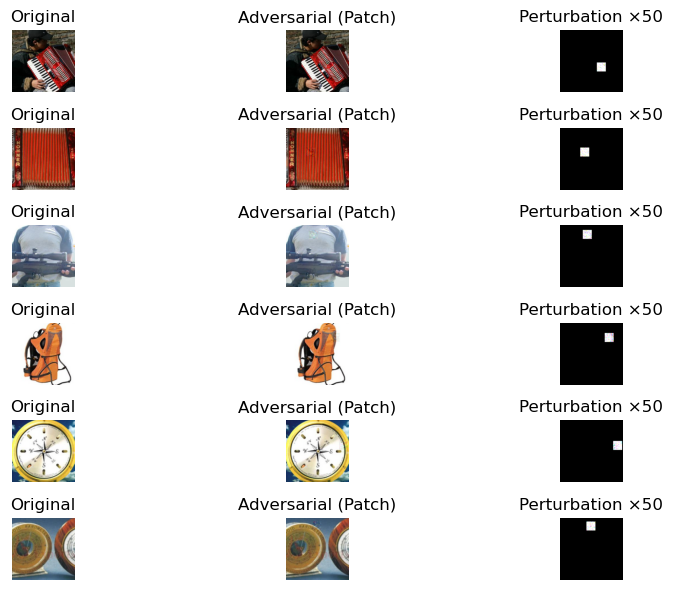

In [19]:
import os, json, ast, requests
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Config ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epsilon = 0.5
alpha = 0.05
steps = 300
patch_size = 32
BATCH_SIZE = 64

mean_vals = torch.tensor([0.485, 0.456, 0.406])[:, None, None].to(device)
std_vals  = torch.tensor([0.229, 0.224, 0.225])[:, None, None].to(device)

# --- Load ResNet-34 ---
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1).to(device).eval()

# --- Load clean dataset (used in Task 1) ---
DATASET_PATH = "./test_dataset"
LABELS_JSON = os.path.join(DATASET_PATH, "labels_list.json")

with open(LABELS_JSON, "r") as f:
    entries = json.load(f)
subset_indices = [int(e.split(":")[0]) for e in entries]

url = "https://gist.githubusercontent.com/fnielsen/4a5c94eaa6dcdf29b7a62d886f540372/raw/imagenet_label_to_wordnet_synset.txt"
synset_text = requests.get(url).text
synset_map = ast.literal_eval(synset_text)

idx_to_wnid = {}
for idx_str, info in synset_map.items():
    idx = int(idx_str)
    if idx in subset_indices:
        wnid = "n" + info["id"].split("-")[0]
        idx_to_wnid[idx] = wnid
wnid_to_global = {wnid: idx for idx, wnid in idx_to_wnid.items()}
valid_wnids = set(wnid_to_global.keys())

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_vals[:, 0, 0], std=std_vals[:, 0, 0])
])

class FilteredImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d)) and d in valid_wnids]
        if not dirs:
            raise ValueError("No matching WNID folders found.")
        dirs.sort()
        return dirs, {cls_name: i for i, cls_name in enumerate(dirs)}

base_ds = FilteredImageFolder(DATASET_PATH, transform=transform)
folder_to_global = {i: wnid_to_global[wnid] for i, wnid in enumerate(base_ds.classes)}

class SubsetDataset(Dataset):
    def __init__(self, base_ds, index_map):
        self.base = base_ds
        self.index_map = index_map
    def __len__(self): return len(self.base)
    def __getitem__(self, idx):
        img, folder_idx = self.base[idx]
        return img, self.index_map[folder_idx]

dataset = SubsetDataset(base_ds, folder_to_global)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- Patch Attack (PGD on 32x32) ---
def patch_pgd_attack(model, x, y, patch_size, eps, alpha, steps):
    B, C, H, W = x.size()
    x = x.clone().detach().to(device)
    y = y.to(device)
    x_orig = x.clone().detach()
    adv = x.clone().detach()

    top = torch.randint(0, H - patch_size, (B,))
    left = torch.randint(0, W - patch_size, (B,))

    for _ in range(steps):
        adv.requires_grad = True
        logits = model(adv)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        grad = adv.grad.detach()

        updated = []
        for i in range(B):
            t, l = top[i], left[i]
            adv_i = adv[i].clone()
            grad_i = grad[i]
            patch_grad = grad_i[:, t:t+patch_size, l:l+patch_size].sign()
            patch = adv_i[:, t:t+patch_size, l:l+patch_size] + alpha * patch_grad
            adv_i[:, t:t+patch_size, l:l+patch_size] = patch
            delta = adv_i - x_orig[i]
            delta = torch.clamp(delta, -eps, eps)
            adv_i = x_orig[i] + delta
            clip_min = (0.0 - mean_vals) / std_vals
            clip_max = (1.0 - mean_vals) / std_vals
            adv_i = torch.max(torch.min(adv_i, clip_max), clip_min)
            updated.append(adv_i)

        adv = torch.stack(updated).detach()

    return adv, top, left

# --- Run attack ---
adv_imgs, adv_lbls, orig_imgs, triplets = [], [], [], []

for x, y in tqdm(loader, desc="Running Untargeted Patch Attack"):
    orig_imgs.append(x.clone())
    x = x.to(device)
    adv, tops, lefts = patch_pgd_attack(model, x, y, patch_size, epsilon, alpha, steps)
    adv_imgs.append(adv.cpu())
    adv_lbls.append(y)

    if len(triplets) < 5:
        for i in range(min(2, x.size(0))):
            o, a = x[i].cpu(), adv[i].cpu()
            triplets.append((o, a, a - o))

adv_imgs_tensor = torch.cat(adv_imgs)
adv_lbls_tensor = torch.cat(adv_lbls)
orig_tensor = torch.cat(orig_imgs)

os.makedirs("AdversarialTestSets", exist_ok=True)
torch.save({"images": adv_imgs_tensor, "labels": adv_lbls_tensor}, "AdversarialTestSets/adv_test_set3_untargeted.pt")
print("Saved to AdversarialTestSets/adv_test_set3_untargeted.pt")

# --- Evaluate ---
@torch.no_grad()
def evaluate(model, loader, topk=(1, 5)):
    correct, total = {k: 0 for k in topk}, {k: 0 for k in topk}
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        _, preds = logits.topk(max(topk), dim=1)
        for k in topk:
            correct[k] += (preds[:, :k] == y.unsqueeze(1)).any(dim=1).sum().item()
            total[k] += y.size(0)
    return {k: correct[k] / total[k] for k in topk}

acc = evaluate(model, DataLoader(TensorDataset(adv_imgs_tensor, adv_lbls_tensor), batch_size=BATCH_SIZE))
print(f"Patch Top-1: {acc[1]*100:.2f}%, Top-5: {acc[5]*100:.2f}%")

# --- L∞ Distance ---
linf = (adv_imgs_tensor - orig_tensor).abs().view(len(orig_tensor), -1).max(dim=1)[0]
print(f"Mean L∞: {linf.mean():.5f}, Max L∞: {linf.max():.5f} (ε = {epsilon})")

# --- Visualize ---
def denorm(img): return (img * std_vals.cpu()) + mean_vals.cpu()
fig, axes = plt.subplots(len(triplets), 3, figsize=(10, 6))
for i, (o, a, d) in enumerate(triplets):
    axes[i][0].imshow(denorm(o).permute(1, 2, 0).clip(0, 1)); axes[i][0].set_title("Original")
    axes[i][1].imshow(denorm(a).permute(1, 2, 0).clip(0, 1)); axes[i][1].set_title("Adversarial (Patch)")
    axes[i][2].imshow((d).permute(1, 2, 0).abs().clip(0, 0.05) * 50); axes[i][2].set_title("Perturbation ×50")
    for ax in axes[i]: ax.axis('off')
plt.tight_layout()
os.makedirs("Patch_Visualizations", exist_ok=True)
plt.savefig("Patch_Visualizations/untargeted_patch_visualization_300.png")
plt.show()
